learn to implement transfer learning using a pre-trained model in Keras.

#### Learning objectives

By the end of this lab, you will:

 - Import necessary libraries and load the dataset.
 - Load a pre-trained model, VGG16, excluding the top layers.
 - Add new layers on top of the base model and compile the model.
 - Train the model on the new dataset.
 - Unfreeze some of the layers of the pre-trained model and fine-tune them.

Step-by-Step Guide:
Step 1: Setup the Environment
Before we start, make sure to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as tensorflow.keras.

In [1]:
from keras.api.applications import VGG16
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten
# Explanation:
# tensorflow is the main library for machine learning in Python.
# Sequential is used to create a model with a linear stack of layers.
# Dense and Flatten are types of layers that we will use in our model.

In [ ]:
# Load the VGG16 model pre-trained on ImageNet
# include_top: whether to include the 3 fully-connected
#     layers at the top of the network.
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [3]:
#### Step 3: Create and Compile the Model 
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [4]:
# Create Placeholder Images
import os
from PIL import Image
import numpy as np

# Create directories if they don't exist
os.makedirs('sample_data/class_a', exist_ok = True)
os.makedirs('sample_data/class_b', exist_ok = True)

# Create 10 sample images for each class
for i in range(10):
    # Create a blank white image for class_a
    # Return a new array of given shape and type, filled with ones.
    img = Image.fromarray(np.ones((224, 224, 3), dtype = np.uint8) * 255)
    img.save(f'sample_data/class_a/img_{i}.jpg')

    # Create a blank black image for class_b
    # @overload
    # def zeros(
    #     shape: _ShapeLike,
    #     dtype: None = ...,
    #     order: _OrderCF = ...,
    #     *,
    #     device: None | L["cpu"] = ...,
    #     like: None | _SupportsArrayFunc = ...,
    # ) -> NDArray[float64]: ...
    # @overload
    # def zeros(
    #     shape: _ShapeLike,
    #     dtype: _DTypeLike[_SCT],
    #     order: _OrderCF = ...,
    #     *,
    #     device: None | L["cpu"] = ...,
    #     like: None | _SupportsArrayFunc = ...,
    # ) -> NDArray[_SCT]: ...
    # @overload
    # def zeros(
    #     shape: _ShapeLike,
    #     dtype: DTypeLike,
    #     order: _OrderCF = ...,
    #     *,
    #     device: None | L["cpu"] = ...,
    #     like: None | _SupportsArrayFunc = ...,
    # ) -> NDArray[Any]: ...
    # has been overloaded
    img = Image.fromarray(np.zeros((224, 224, 3), dtype = np.uint8))
    img.save(f'sample_data/class_b/img_{i}.jpg')

print("Sample images created in 'sample_data/'")

Sample images created in 'sample_data/'


In [5]:
# Step 4: Train the Model¶
# Load the preprocess the dataset
import tensorflow as tf
import keras
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0 # Rescale the image
    return image

# Define the function to load the dataset
def load_dataset(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return file_paths, labels, class_names

# Load the dataset
directory = 'sample_data'
file_paths, labels, class_names = load_dataset(directory)

# Create a tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(file_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Verify if the dataset has loaded images correctly
print(f"Found {len(file_paths)} images belonging to {len(class_names)} classes.")

# Define a simple model for demonstration purposes
model = Sequential([
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
if len(file_paths) > 0:
    model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Found 20 images belonging to 2 classes.
Epoch 1/10


/Users/whiteknight/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5000 - loss: 0.6211
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: 0.4632
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5000 - loss: 0.3926
Epoch 4/10


2025-03-14 15:50:54.425025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/whiteknight/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-14 15:50:54.514304: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.3460
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.3455
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.3452
Epoch 7/10


2025-03-14 15:50:54.688459: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.3449
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.3446
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.3442
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.3439


2025-03-14 15:50:55.028005: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


GitHub Copilot
Since ImageDataGenerator is deprecated, we will use tf.data to load and preprocess the dataset. Here's how you can achieve the same functionality using tf.data:

Load and preprocess the dataset.
Create a tf.data.Dataset object.
Train the model.
Here's the updated code:

1 vulnerability
In this code:

The load_and_preprocess_image function loads and preprocesses the images by reading the file, decoding the JPEG image, resizing it to the target size, and rescaling the pixel values.
The load_dataset function loads the dataset from the specified directory and returns the file paths, labels, and class names.
The tf.data.Dataset object is created from the file paths and labels, and the images are loaded and preprocessed using the load_and_preprocess_image function.
The dataset is split into training and validation sets.
A simple model is defined, compiled, and trained using the training and validation datasets.
Similar code found with 2 license types - View matches
whiteknight0x00
whats the meaning of channels = 3?

GitHub Copilot
In the context of image processing, the term "channels" refers to the different color components that make up an image. Each channel represents a specific color in the image. The most common color channels are:

1 channel: Grayscale image (only intensity values, no color information).
3 channels: RGB image (Red, Green, and Blue channels).
4 channels: RGBA image (Red, Green, Blue, and Alpha channels, where Alpha represents transparency).
When you see channels=3, it means that the image has three color channels, which typically correspond to the RGB color model. Each pixel in the image is represented by three values: one for the red component, one for the green component, and one for the blue component.

For example, in the following code snippet from your active file, the decode_jpeg function is used to decode a JPEG image, and the channels parameter specifies the number of color channels in the output image:

In [ ]:
# decode_jpeg = tf_export(
#     'io.decode_jpeg',
#     'image.decode_jpeg',
#     v1=['io.decode_jpeg', 'image.decode_jpeg'])(
#         dispatch.add_dispatch_support(gen_image_ops.decode_jpeg))

If you set channels=3, the decoded image will have three color channels (RGB). If you set channels=1, the decoded image will be a grayscale image with only one channel.

#### Exercise 1: Visualize Training and Validation Loss

**Objective:** Plot the training and validation loss to observe the learning process of the model.

**Instructions:**
1. Modify the training code to include validation data.
2. Plot the training and validation loss for each epoch.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0 # Rescale the image
    return image

# Define the function to load the dataset
def load_dataset(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return file_paths, labels, class_names

# Load the dataset
directory = 'sample_data'
file_paths, labels, class_names = load_dataset(directory)

# Create a tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)
# OK, I found another mistake.
# I should dig into the source code to find what has batch() and prefetch() methods done.
# I think I found the answer.
# It's not because of I didn't shuffle the dataset or I 'HAVE TRAINED' the model.
# dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(file_paths))
print(train_size)
print(len(file_paths))
val_size = len(file_paths) - train_size
# def take(self, count, name=None) -> "DatasetV2":
#     """Creates a `Dataset` with at most `count` elements from this dataset.

#     >>> dataset = tf.data.Dataset.range(10)
#     >>> dataset = dataset.take(3)
#     >>> [a.item() for a in dataset.as_numpy_iterator()]
#     [0, 1, 2]

#     Args:
#       count: A `tf.int64` scalar `tf.Tensor`, representing the number of
#         elements of this dataset that should be taken to form the new dataset.
#         If `count` is -1, or if `count` is greater than the size of this
#         dataset, the new dataset will contain all elements of this dataset.
#       name: (Optional.) A name for the tf.data operation.

#     Returns:
#       A new `Dataset` with the transformation applied as described above.
#     """
#     # Loaded lazily due to a circular dependency (dataset_ops ->
#     # take_op -> dataset_ops).
#     # pylint: disable=g-import-not-at-top,protected-access
#     from tensorflow.python.data.ops import take_op
#     return take_op._take(self, count, name=name)
#     # pylint: enable=g-import-not-at-top,protected-access
# [(x) for x in train_dataset.as_numpy_iterator()]
# The components of the resulting element will have an additional outer
#     dimension, which will be `batch_size` (or `N % batch_size` for the last
#     element if `batch_size` does not divide the number of input elements `N`
#     evenly and `drop_remainder` is `False`). If your program depends on the
#     batches having the same outer dimension, you should set the `drop_remainder`
#     argument to `True` to prevent the smaller batch from being produced.

#     Note: If your program requires data to have a statically known shape (e.g.,
#     when using XLA), you should use `drop_remainder=True`. Without
#     `drop_remainder=True` the shape of the output dataset will have an unknown
#     leading dimension due to the possibility of a smaller final batch.

#     Args:
#       batch_size: A `tf.int64` scalar `tf.Tensor`, representing the number of
#         consecutive elements of this dataset to combine in a single batch.
#       drop_remainder: (Optional.) A `tf.bool` scalar `tf.Tensor`, representing
#         whether the last batch should be dropped in the case it has fewer than
#         `batch_size` elements; the default behavior is not to drop the smaller
#         batch.
#       num_parallel_calls: (Optional.) A `tf.int64` scalar `tf.Tensor`,
#         representing the number of batches to compute asynchronously in
#         parallel.
#         If not specified, batches will be computed sequentially. If the value
#         `tf.data.AUTOTUNE` is used, then the number of parallel
#         calls is set dynamically based on available resources.
#       deterministic: (Optional.) When `num_parallel_calls` is specified, if this
#         boolean is specified (`True` or `False`), it controls the order in which
#         the transformation produces elements. If set to `False`, the
#         transformation is allowed to yield elements out of order to trade
#         determinism for performance. If not specified, the
#         `tf.data.Options.deterministic` option (`True` by default) controls the
#         behavior.
#       name: (Optional.) A name for the tf.data operation.
# """Creates a `Dataset` that prefetches elements from this dataset.

#     Most dataset input pipelines should end with a call to `prefetch`. This
#     allows later elements to be prepared while the current element is being
#     processed. This often improves latency and throughput, at the cost of
#     using additional memory to store prefetched elements.

#     Note: Like other `Dataset` methods, prefetch operates on the
#     elements of the input dataset. It has no concept of examples vs. batches.
#     `examples.prefetch(2)` will prefetch two elements (2 examples),
#     while `examples.batch(20).prefetch(2)` will prefetch 2 elements
#     (2 batches, of 20 examples each).

#     >>> dataset = tf.data.Dataset.range(3)
#     >>> dataset = dataset.prefetch(2)
#     >>> [a.item() for a in dataset.as_numpy_iterator()]
#     [0, 1, 2]

#     Args:
#       buffer_size: A `tf.int64` scalar `tf.Tensor`, representing the maximum
#         number of elements that will be buffered when prefetching. If the value
#         `tf.data.AUTOTUNE` is used, then the buffer size is dynamically tuned.
#       name: Optional. A name for the tf.data transformation.

#     Returns:
#       A new `Dataset` with the transformation applied as described above.
#     """
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
# Why would I skip the training dataset and then take the train_size dataset?
# Of course it would be empty!
# Stupid mistake but I read the source code.
# Shit!
val_dataset = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)


# Ensure that the validation dataset is not empty
if val_size == 0:
    raise ValueError("Validation dataset is empty. Please ensure there are enough samples to create a validation set.")

# Define a simple model for demonstration purposes
model = Sequential([
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# TODO: So there is an error in the code, which I am not able to figure out.
# The error is: KeyError: 'val_loss'
# I am not for sure if the error is caused by the pre-trained model.
# I think the error is caused is caused by empty validation dataset, So I will figure it out tomorrow.
# End of the day.
# Date: 13/03/2025 10:50 PM
history = model.fit(train_dataset, validation_data = val_dataset, epochs=10)


print(history.history)
# Plot training and validation loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.api.applications import VGG16
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten

# Load and preprocess the dataset
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Rescale the image
    return image

# Define the function to load the dataset
def load_dataset(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return file_paths, labels, class_names

# Load the dataset
directory = 'sample_data'
file_paths, labels, class_names = load_dataset(directory)

# Create a tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# 🔄 Fix: Shuffle before splitting
# Update: I think I have found the issue, that is the dataset is not shuffled before splitting.
# But still not familiar with functions. I will look through the source code in the day.
# Programming is no black box. I will dig it out.
# dataset = dataset.shuffle(len(file_paths), reshuffle_each_iteration=False)
print(f"train_size: {train_size}")
print(f"file_paths: {len(file_paths)}")
print(f"val_size: {int(0.8 * len(file_paths))}")
samples = sum(1 for _ in dataset)
print(f"Total samples: {samples}")


# Update: train_size is 16, and the file_paths is 20, so the val_size is 4.
# I want to know wtf happened in the following codes.
# 🔄 Fix: Split first, batch later
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
# Split the dataset into training and validation sets

# train_size = int(0.8 * len(file_paths))
# val_size = len(file_paths) - train_size
# train_dataset = dataset.take(train_size)
# val_dataset = dataset.skip(train_size)  # Ensure val_dataset is not empty
train_samples = sum(1 for _ in train_dataset)
val_samples = sum(1 for _ in val_dataset)

print(f"Train dataset size: {train_samples}")
print(f"Validation dataset size: {val_samples}")

# Ensure that the validation dataset is not empty
# if val_size == 0:
    # raise ValueError("Validation dataset is empty. Please ensure there are enough samples to create a validation set.")

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Print the keys of the history object to verify what metrics are being tracked
print(history.history.keys())

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
else:
    print("Warning: No validation loss found. Skipping validation plot.")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Exercise 2: Experiment with Different Optimizers

**Objective:** Experiment with different optimizers and observe their impact on model performance.

**Instructions:**
1. Change the optimizer from `adam` to `sgd` and `rmsprop`.
2. Retrain the model with each optimizer and compare the accuracy.

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 1.0000 - loss: 0.2577 - val_accuracy: 1.0000 - val_loss: 0.6862
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.2573 - val_accuracy: 1.0000 - val_loss: 0.6853
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.2570 - val_accuracy: 1.0000 - val_loss: 0.6843
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.2566 - val_accuracy: 1.0000 - val_loss: 0.6833
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.2562 - val_accuracy: 1.0000 - val_loss: 0.6824
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.2559 - val_accuracy: 1.0000 - val_loss: 0.6814
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.2555 - val_accuracy: 1.0000 - val_loss: 0.6804
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.2552 - val_accuracy: 1.0000 - val_loss: 0.6795

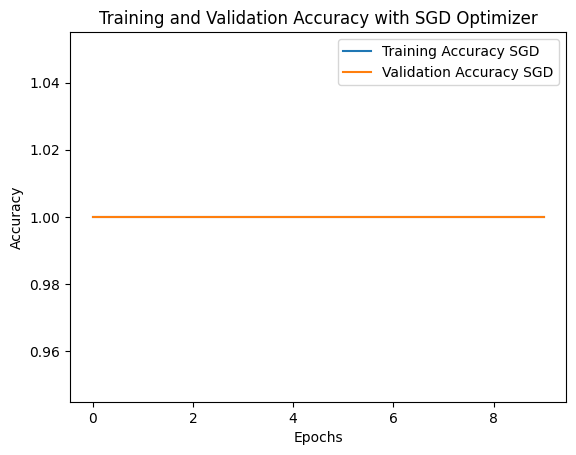

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 1.0000 - loss: 0.2577 - val_accuracy: 1.0000 - val_loss: 0.6851
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.2569 - val_accuracy: 1.0000 - val_loss: 0.6836
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.2564 - val_accuracy: 1.0000 - val_loss: 0.6823
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.2559 - val_accuracy: 1.0000 - val_loss: 0.6812
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.2554 - val_accuracy: 1.0000 - val_loss: 0.6801
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.2551 - val_accuracy: 1.0000 - val_loss: 0.6792
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.2547 - val_accuracy: 1.0000 - val_loss: 0.6782
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.2543 - val_accuracy: 1.0000 - val_loss: 0.6773

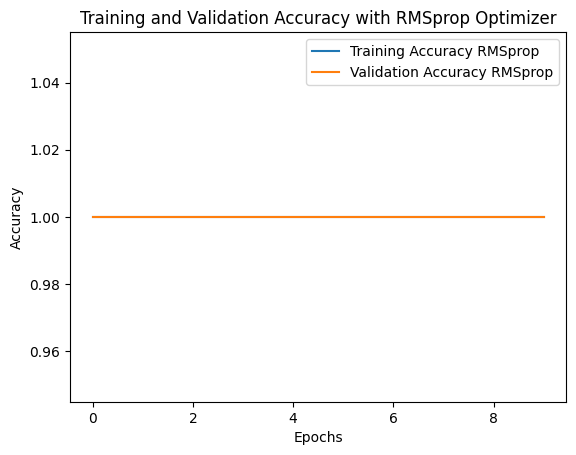

In [6]:
from keras.api.models import clone_model
import matplotlib.pyplot as plt

def reset_model(model):
    # Clone the model to reset weights
    # """Clone a Functional or Sequential `Model` instance.

    # Model cloning is similar to calling a model on new inputs,
    # except that it creates new layers (and thus new weights) instead
    # of sharing the weights of the existing layers.

    # Note that
    # `clone_model` will not preserve the uniqueness of shared objects within the
    # model (e.g. a single variable attached to two distinct layers will be
    # restored as two separate variables).
    # Returns:
    #     An instance of `Model` reproducing the behavior
    #     of the original model, on top of new inputs tensors,
    #     using newly instantiated weights. The cloned model may behave
    #     differently from the original model if a custom `clone_function`
    #     or `call_function` modifies a layer or layer call.
    model_clone = clone_model(model)
    model_clone.set_weights(model.get_weights())
    return model_clone

# Define the function to load the dataset
def load_dataset(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return file_paths, labels, class_names

# Prepare to reset the model for each optimizer test
initial_model = reset_model(model)  # Assume 'model' is the initial compiled model

directory = 'sample_data'
file_paths, labels, class_names = load_dataset(directory)

# Create a tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

# Experiment with SGD optimizer
sgd_model = reset_model(initial_model) # Reset the model
sgd_model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Train the model
sgd_model_history = sgd_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Plot training and validation loss
plt.plot(sgd_model_history.history['accuracy'], label='Training Accuracy SGD')
plt.plot(sgd_model_history.history['val_accuracy'], label='Validation Accuracy SGD')
plt.title('Training and Validation Accuracy with SGD Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Experiment with RMSprop optimizer
rmsprop_model = reset_model(initial_model)  # Reset the model
rmsprop_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_rmsprop = rmsprop_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Plot training and validation loss
plt.plot(history_rmsprop.history['accuracy'], label='Training Accuracy RMSprop')
plt.plot(history_rmsprop.history['val_accuracy'], label='Validation Accuracy RMSprop')
plt.title('Training and Validation Accuracy with RMSprop Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Exercise 3: Evaluate the Model on a Test Set
Objective: Evaluate the fine-tuned model on an unseen test set to assess its generalization performance.

Instructions:

Load a separate test set.
Evaluate the model on this test set and report the accuracy and loss.

In [7]:
def load_dataset(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return file_paths, labels, class_names

# Load the dataset
directory = 'sample_data'
file_paths, labels, class_names = load_dataset(directory)

# Create a tf.data.Dataset object
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
test_dataset = test_dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Loss: {test_loss * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.3436
Test Loss: 34.36%
Test Accuracy: 1.0000
